# Imports, Load data

In [53]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# load in score function
from metric import score

# format display 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

# global random state
random_state = 0

In [224]:
# datetime transforms
dt_transforms = [
    pl.col('timestamp').str.to_datetime(), 
    (pl.col('timestamp').str.to_datetime().dt.year() - 2000).cast(pl.UInt8).alias('year'), 
    pl.col('timestamp').str.to_datetime().dt.month().cast(pl.UInt8).alias('month'),
    pl.col('timestamp').str.to_datetime().dt.day().cast(pl.UInt8).alias('day'), 
    pl.col('timestamp').str.to_datetime().dt.hour().cast(pl.UInt8).alias('hour')
]

# cast features to int16 and uint16
data_transforms = [
    pl.col('anglez').cast(pl.Int16),
    (pl.col('enmo') * 1000).cast(pl.UInt16),
]

In [225]:
# read in the data
root = 'data/'

# load data
train_series = pl.scan_csv(root + 'single_user_1.csv').with_columns(
    dt_transforms + data_transforms
    ).drop('asleep')
train_events = pl.read_csv(root + 'train_events.csv').with_columns(
    dt_transforms
    )
test_series = pl.scan_parquet(root + 'test_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

# Filter data, Create features

In [226]:
# getting series ids as a list
series_ids = train_events['series_id'].unique(maintain_order=True).to_list()
print(f'Number of total series: {len(series_ids)}')

# removing users with mismatched onset/wakeup counts: 
onset_counts = train_events.filter(pl.col('event')=='onset').group_by('series_id').count().sort('series_id')['count']
wakeup_counts = train_events.filter(pl.col('event')=='wakeup').group_by('series_id').count().sort('series_id')['count']
counts = pl.DataFrame({'series_id':sorted(series_ids), 'onset_counts':onset_counts, 'wakeup_counts':wakeup_counts})
count_mismatches = counts.filter(counts['onset_counts'] != counts['wakeup_counts'])
train_series = train_series.filter(~pl.col('series_id').is_in(count_mismatches['series_id']))
train_events = train_events.filter(~pl.col('series_id').is_in(count_mismatches['series_id']))

# update list of series ids, not including series with no non-null values
series_ids = train_events.drop_nulls()['series_id'].unique(maintain_order=True).to_list()
print(f'Number of series after removing mismatched counts: {len(series_ids)}')

Number of total series: 277
Number of series after removing mismatched counts: 269


C:\Users\heefj\AppData\Local\Temp\ipykernel_8476\947715849.py:6: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  onset_counts = train_events.filter(pl.col('event')=='onset').group_by('series_id').count().sort('series_id')['count']
C:\Users\heefj\AppData\Local\Temp\ipykernel_8476\947715849.py:7: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  wakeup_counts = train_events.filter(pl.col('event')=='wakeup').group_by('series_id').count().sort('series_id')['count']


In [227]:
# manula rolling_max function because to address "not implemented" error in polars
def rolling_max(series):
    return pd.Series(series).rolling(window_size, center=True, min_periods=1).max()

In [229]:
# cell without multiple minute counts

features, feature_cols = [pl.col('hour'), pl.col('anglez'), pl.col('enmo')], ['hour', 'anglez', 'enmo']

features += [
    pl.col('enmo').rolling_mean(window_size=60, center=True, min_periods=1).alias(f'enmo_{5}m_mean'),
    pl.col('enmo').apply(lambda x: rolling_max(x, 60)).alias(f'enmo_{5}m_max')
]

feature_cols += [ 
    f'enmo_{5}m_mean', f'enmo_{5}m_max'
]

C:\Users\heefj\AppData\Local\Temp\ipykernel_8476\2026851032.py:7: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col('enmo').apply(lambda x: rolling_max(x, 60)).alias(f'enmo_{5}m_max')


In [230]:
# # features holds polars cols, feature_cols holds the names of the feature cols
# features, feature_cols = [pl.col('hour')], ['hour']

# # create rolling features for every [5, 30, 120, 480] minute interval
# for mins in [5, 30, 120, 480] :
#     features += [
#         # multiply by 12 because of 5 second intervals
#         pl.col('enmo').rolling_mean(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'enmo_{mins}m_mean'),
#         pl.col('enmo').rolling_max(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'enmo_{mins}m_max')
#     ]

#     feature_cols += [ 
#         f'enmo_{mins}m_mean', f'enmo_{mins}m_max'
#     ]

#     # 
#     for var in ['enmo', 'anglez'] :
#         features += [
#             (pl.col(var).diff().abs().rolling_mean(12 * mins, center=True, min_periods=1) * 10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_mean'),
#             (pl.col(var).diff().abs().rolling_max(12 * mins, center=True, min_periods=1) * 10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_max')
#         ]

#         feature_cols += [ 
#             f'{var}_1v_{mins}m_mean', f'{var}_1v_{mins}m_max'
#         ]

# # id cols
# id_cols = ['series_id', 'step', 'timestamp']

In [231]:
features

[<Expr ['col("hour")'] at 0x254671980E0>,
 <Expr ['col("anglez")'] at 0x25467199C40>,
 <Expr ['col("enmo")'] at 0x2546719B6B0>,
 <Expr ['col("enmo").rolling_mean().ali…'] at 0x254670E1A30>,
 <Expr ['col("enmo").map_list().alias("…'] at 0x2546719D160>]

In [232]:
# look at features
print(f'Feature columns: {feature_cols}, {len(feature_cols)}')

Feature columns: ['hour', 'anglez', 'enmo', 'enmo_5m_mean', 'enmo_5m_max'], 5


In [233]:
# check before
train_series.collect().head()

series_id,step,timestamp,anglez,enmo,year,month,day,hour
str,i64,"datetime[μs, UTC]",i16,u16,u8,u8,u8,u8
"""038441c925bb""",0,2018-08-14 19:30:00 UTC,2,21,18,8,14,19
"""038441c925bb""",1,2018-08-14 19:30:05 UTC,2,21,18,8,14,19
"""038441c925bb""",2,2018-08-14 19:30:10 UTC,2,21,18,8,14,19
"""038441c925bb""",3,2018-08-14 19:30:15 UTC,2,21,18,8,14,19
"""038441c925bb""",4,2018-08-14 19:30:20 UTC,2,21,18,8,14,19


In [234]:
# add features to train and test series
train_series = train_series.with_columns(
    features
).select(id_cols + feature_cols)

test_series = test_series.with_columns(
    features
).select(id_cols + feature_cols)

In [235]:
# check after
train_series.collect().head()

c:\Users\heefj\anaconda3\envs\sleep_env\Lib\site-packages\polars\series\series.py:5291: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._s.apply_lambda(function, pl_return_dtype, skip_nulls)


KeyboardInterrupt: 

In [46]:
def make_train_dataset(train_data, train_events, drop_nulls=False) :
    # get series ids
    series_ids = train_data['series_id'].unique(maintain_order=True).to_list()

    # create empty dataframes
    X, y = pl.DataFrame(), pl.DataFrame()

    # normalize all features by dividing by std
    sample = train_data.with_columns(
        [(pl.col(col) / pl.col(col).std()).cast(pl.Float32) for col in feature_cols if col != 'hour']
    )
    
    # get events for the first user
    events = train_events.filter(pl.col('series_id') == '038441c925bb')
    
    # remove datapoints on dates where no data was recorded
    if drop_nulls : 
        sample = sample.filter(
            pl.col('timestamp').dt.date().is_in(events['timestamp'].dt.date())
        )
    
    # add sample to X dataframe
    X = X.vstack(sample[id_cols + feature_cols])

    # get onsets and wakeups
    onsets = events.filter((pl.col('event') == 'onset') & (pl.col('step') != None))['step'].to_list()
    wakeups = events.filter((pl.col('event') == 'wakeup') & (pl.col('step') != None))['step'].to_list()

    # iterate through onsets, wakeups for the user to create 'asleep' col
    y = y.vstack(sample.with_columns(
        sum([(onset <= pl.col('step')) & (pl.col('step') <= wakeup) for onset, wakeup in zip(onsets, wakeups)]).cast(pl.Boolean).alias('asleep')
        ).select('asleep')
        )
    
    y = y.to_numpy().ravel()
    
    return X, y

In [ ]:
def get_events(series, classifier):
    '''
    Takes a time series and a classifier and returns a formatted submission dataframe.
    '''
    
    series_ids = series['series_id'].unique(maintain_order=True).to_list()
    events = pl.DataFrame(schema={'series_id':str, 'step':int, 'event':str, 'score':float})

    for idx in tqdm(series_ids) : 

        # Collecting sample and normalizing features
        scale_cols = [col for col in feature_cols if (col != 'hour') & (series[col].std() !=0)]
        X = series.filter(pl.col('series_id') == idx).select(id_cols + feature_cols).with_columns(
            [(pl.col(col) / series[col].std()).cast(pl.Float32) for col in scale_cols]
        )

        # Applying classifier to get predictions and scores
        preds, probs = classifier.predict(X[feature_cols]), classifier.predict_proba(X[feature_cols])[:, 1]

        #NOTE: Considered using rolling max to get sleep periods excluding <30 min interruptions, but ended up decreasing performance
        X = X.with_columns(
            pl.lit(preds).cast(pl.Int8).alias('prediction'), 
            pl.lit(probs).alias('probability')
                        )
        
        # Getting predicted onset and wakeup time steps
        pred_onsets = X.filter(X['prediction'].diff() > 0)['step'].to_list()
        pred_wakeups = X.filter(X['prediction'].diff() < 0)['step'].to_list()
        
        if len(pred_onsets) > 0 : 
            
            # Ensuring all predicted sleep periods begin and end
            if min(pred_wakeups) < min(pred_onsets) : 
                pred_wakeups = pred_wakeups[1:]

            if max(pred_onsets) > max(pred_wakeups) :
                pred_onsets = pred_onsets[:-1]

            # Keeping sleep periods longer than 30 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset >= 12 * 30]

            for onset, wakeup in sleep_periods :
                # Scoring using mean probability over period
                score = X.filter((pl.col('step') >= onset) & (pl.col('step') <= wakeup))['probability'].mean()

                # Adding sleep event to dataframe
                events = events.vstack(pl.DataFrame().with_columns(
                    pl.Series([idx, idx]).alias('series_id'), 
                    pl.Series([onset, wakeup]).alias('step'),
                    pl.Series(['onset', 'wakeup']).alias('event'),
                    pl.Series([score, score]).alias('score')
                ))

    # Adding row id column
    events = events.to_pandas().reset_index().rename(columns={'index':'row_id'})

    return events

In [52]:
train_series

<LazyFrame [28 cols, {"series_id": String … "anglez_1v_480m_max": UInt32}] at 0x2546719B5F0>

In [47]:
# create the training data (no mismatched counts)
train_data = train_series.filter(pl.col('series_id').is_in(series_ids)).collect()#.sample(int(1e6))

PanicException: not implemented

In [ ]:
# create features and target
X_train, y_train = make_train_dataset(train_data, train_events)

In [ ]:
# recover memory
del train_data 
gc.collect()

# Model 1

In [6]:
# create pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('logreg', LogisticRegression(n_jobs=-1, random_state=random_state))])

In [7]:
# cross validate
scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')

# print results
scores, scores.mean()

(array([0.78894067, 0.83249574, 0.7408778 , 0.78022965, 0.78140229]),
 0.7847892300194931)

In [8]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# fit pipeline
pipe.fit(X_train, y_train)

# get preds
preds = pipe.predict(X_test)


print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83     41789
           1       0.70      0.74      0.72     23875

    accuracy                           0.79     65664
   macro avg       0.77      0.78      0.78     65664
weighted avg       0.79      0.79      0.79     65664



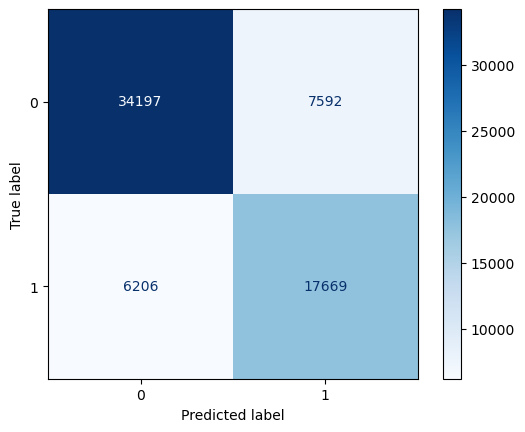

In [9]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap='Blues');

In [10]:
# add preds col
df_copy = df.copy()
df_copy['pred'] = pipe.predict(X)

# check
df_copy.head()

,series_id,step,anglez,enmo,date,asleep,anglez_diff,anglez_rolling_mean,anglez_rolling_std,enmo_diff,enmo_rolling_mean,enmo_rolling_std,pred
0,038441c925bb,3240,67.175,0.015,2018-08-15,0,0.000,67.175,0.000,0.000,0.015,0.000,0
1,038441c925bb,3241,68.881,0.021,2018-08-15,0,1.706,68.028,1.706,0.006,0.018,1.706,0
2,038441c925bb,3242,73.114,0.034,2018-08-15,0,4.233,69.723,4.233,0.013,0.024,4.233,0
3,038441c925bb,3243,73.692,0.030,2018-08-15,0,0.578,70.715,0.578,-0.004,0.025,0.578,0
4,038441c925bb,3244,72.685,0.020,2018-08-15,0,-1.007,71.109,-1.007,-0.011,0.024,-1.007,0


In [11]:
# rows where prediction switches from 0 to 1 or 1 to 0
df_copy["pred_switch"] = (df_copy["pred"].diff() != 0).astype(int)

In [12]:
# look at the value counts
df_copy["pred_switch"].value_counts()

pred_switch
0    326251
1      2069
Name: count, dtype: int64

- For this user, we have 19 valid nights of data, meaning a perfect model would have 38 rows where sleep state switched.
- Currently, our model has over 2000. This is because at any given 5-second timestep, our model is predicting whether the user is asleep or awake at that given moment. This would include times in the night where the user briefly woke up.
- We want to identify the sleep window, and return the step where it began and where it ended on each day.

In [130]:
# group by the date to take the first occurence of predicted onset
predicted_onset = df_copy.query("pred_switch == 1 & pred == 1").groupby("date")['step'].min()

# idk
predicted_wakeup = df_copy.query("pred_switch == 1 & pred == 0").groupby("date")['step'].min()